# Úkol č. 3 - Segmentace zákazníků e-shopu (do 7. ledna)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka)
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("eshop.csv")
df_old = df

In [6]:
#Reviewing dataset
cust_count = df['Customer ID'].value_counts()
#display(cust_count)

country_count = df['Country'].value_counts()
df['Country'] = df['Country'].fillna("Unknown");
#display(country_count)

display(df.head())
display(df.info())

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
Customer ID    22408 non-null int64
Date           22408 non-null object
Subtotal       22408 non-null float64
Country        22408 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 700.3+ KB


None

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


In [7]:
import datetime

# Frequency = Count of rows per Customer ID
def get_frequency(data):
    return data.groupby("Customer ID")['Date'].count()

# Recency = Count of days since last visit
# Taking most recent date per Client ID and subtracting it from today's date
def get_rec(dt):
    return (datetime.datetime.today() - dt).days

def get_recency(data):
    today = datetime.date.today()
    data['Date'] = pd.to_datetime(data['Date'])
    customers = data.groupby("Customer ID")['Date']
    dates = []
    for c in customers:
        date = get_rec(c[1].max())
        dates.append(date)
        
    return dates
# Monetary = Sum of subtotals per Client ID
def get_monetary(data):
    monetary = []
    monetary = data.groupby("Customer ID")['Subtotal'].sum()
    return monetary

In [8]:
# Filling dataframe with regular RFM
rmf = pd.DataFrame();

rmf["frequency"] = get_frequency(df)
rmf["recency"] = get_recency(df)
rmf["monetary"] = get_monetary(df)

display(rmf.head())

,frequency,recency,monetary
Customer ID,,,
7,3,1512,15.54
9,1,4251,13.20
30,1,4226,36.20
34,1,4304,86.00
38,1,4298,38.40


### Vizualizace RFM dat

In [9]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

rmf_old = rmf

## funkce prevzata ze 4. cviceni
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendrogram hierarchického shlukování (oříznutý)')
        plt.xlabel('index bodu nebo (velikost shluku)')
        plt.ylabel('vzdálenost')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [7]:
import seaborn as sns 

# pomocna funkce k vykreslení grafu k RMF datasetu
def plot_scatter(data,x,y, hue = 'frequency', col = 'cool', with_hue = 1, log_x=0, log_y=0):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('#EAEAEA')
    ax = fig.add_subplot(111)
    ax.set_facecolor('#F2F2F2')
    if(with_hue == 1):
        h = data[hue]
        h_log = np.log(h)
        vysl = plt.scatter(x=data[x], y=data[y], c=h_log, cmap=col, alpha=0.2)
    else:
        vysl = plt.scatter(x=data[x], y=data[y], c="black", alpha=0.1)
        
    x_lab = x
    y_lab = y
    if(log_x==1):
        plt.xscale('log')
        x_lab += " log"
    if(log_y==1):
        plt.yscale('log')
        y_lab += " log"
    
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    plt.show()
    

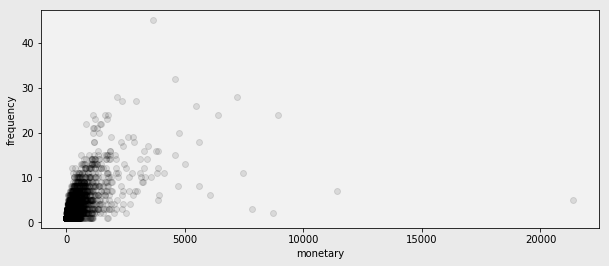

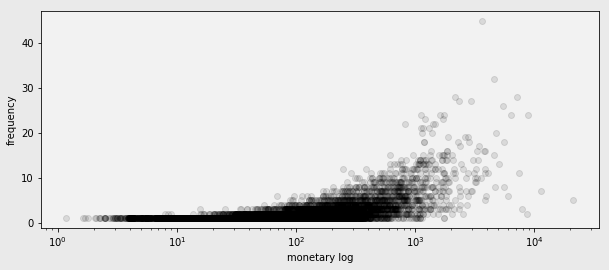

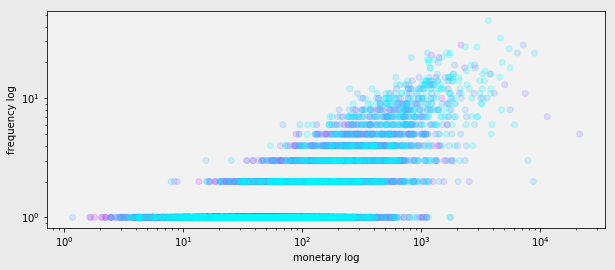

In [8]:
plot_scatter(rmf, 'monetary', 'frequency', with_hue = 0, log_x=0, log_y=0)
plot_scatter(rmf, 'monetary', 'frequency', with_hue = 0, log_x=1, log_y=0)
plot_scatter(rmf, 'monetary', 'frequency', 'recency', with_hue = 1, log_x=1, log_y=1)

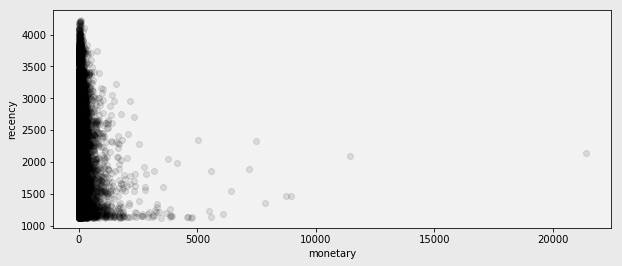

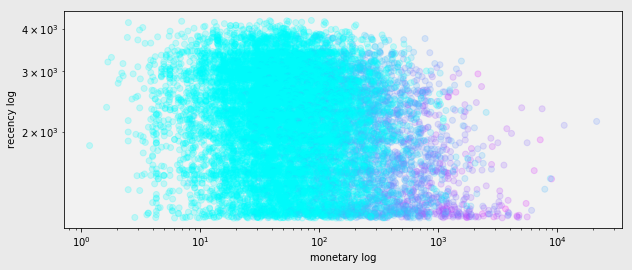

In [9]:
plot_scatter(rmf, 'monetary', 'recency', with_hue = 0,  log_x=0, log_y=0)
#plot_scatter(rmf, 'monetary', 'recency', with_hue = 0,  log_x=0, log_y=1)
plot_scatter(rmf, 'monetary',  'recency', 'frequency', with_hue = 1,  log_x=1, log_y=1)


Z předchozích pohledů lze vidět, že data jsou poměrně rovnoměrně distribuovaná na ose Recency a ne jinde.

### Normalizace dat

Normalizace všech tří příznaků do intervalu 0-1.

In [10]:
from sklearn import preprocessing
#normalizace do intervalu 0-1

def normalizeMinMax(data):
    #scaler = preprocessing.MinMaxScaler()
    #preprocessing.MinMaxScaler(copy=True, feature_range=(0,1))
    #scaler.fit(data.T)
    #data_new = pd.DataFrame(scaler.transform(data.T).T, columns=data.columns, index=data.index)
    result = data.copy()
    print('\nInput data: ')
    display(result.head())
    for col in data.columns:
        print("Min - Max Normalizing column: ",col)
        max_val = data[col].max()
        min_val = data[col].min()
        result[col] = (data[col] - min_val) / (max_val - min_val)
    
    return result


norm_mm = normalizeMinMax(rmf)
print("Min-max: ")
display(norm_mm.head(5))

    
def plot_rmf(data,x,y,z, title):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('#EAEAEA')
    pairs = [[x,y,z],[x,z, y],[z,y, x]]
    ax1 = fig.add_subplot(111)
    ax1.set_facecolor('#F2F2F2')
    ax1.scatter(data[pairs[0][0]],data[pairs[0][1]], c=data[pairs[0][2]], cmap='cool', alpha=0.4)
    ax1.set(xlabel=pairs[0][0], ylabel=pairs[0][1])
    fig.suptitle(title, fontsize=14)
    plt.show()
    


Input data: 


,frequency,recency,monetary
Customer ID,,,
7,3,1433,15.54
9,1,4172,13.20
30,1,4147,36.20
34,1,4225,86.00
38,1,4219,38.40


Min - Max Normalizing column:  frequency
Min - Max Normalizing column:  recency
Min - Max Normalizing column:  monetary
Min-max: 


,frequency,recency,monetary
Customer ID,,,
7,0.045455,0.100226,0.000671
9,0.000000,0.982920,0.000562
30,0.000000,0.974863,0.001637
34,0.000000,1.000000,0.003965
38,0.000000,0.998066,0.001740


In [11]:
def plot_norm(data,x,y,z, title):
    fig = plt.figure(figsize=(17,4))
    fig.patch.set_facecolor('#EAEAEA')
    pairs = [[x,y,z],[x,z, y],[z,y, x]]
    ax1 = fig.add_subplot(131)
    ax1.set_title('Front side')
    ax1.set_facecolor('#F2F2F2')
    ax2 = fig.add_subplot(132)
    ax2.set_title('From above')
    ax2.set_facecolor('#F2F2F2')
    ax3 = fig.add_subplot(133)
    ax3.set_title('Opposite side')
    ax3.set_facecolor('#F2F2F2')

    ax1.scatter(data[pairs[0][0]],data[pairs[0][1]], c=data[pairs[0][2]], cmap='cool', alpha=0.4)
    ax1.set(xlabel=pairs[0][0], ylabel=pairs[0][1])
    ax2.scatter(data[pairs[1][0]],data[pairs[1][1]], c=data[pairs[1][2]], cmap='cool', alpha=0.4 )
    ax2.set(xlabel=pairs[1][0], ylabel=pairs[1][1])
    ax3.scatter(data[pairs[2][0]],data[pairs[2][1]], c=data[pairs[2][2]], cmap='cool', alpha=0.4 )
    ax3.set(xlabel=pairs[2][0], ylabel=pairs[2][1])
        
    fig.suptitle(title, fontsize=14)
    plt.show()
    

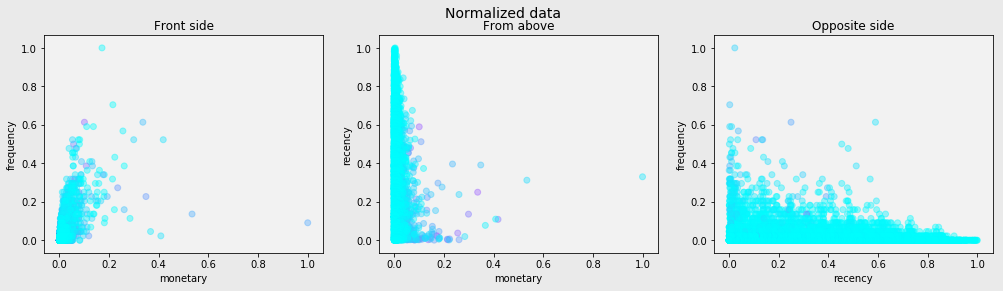

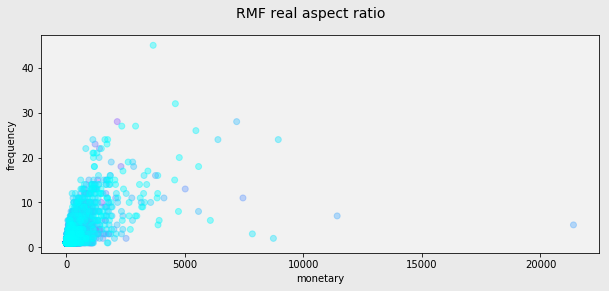

In [12]:
plot_norm(norm_mm,'monetary',  'frequency', 'recency', "Normalized data")
plot_rmf(rmf,'monetary',  'frequency', 'recency', "RMF real aspect ratio")

### Standardizace dat

In [13]:
from scipy.stats import zscore

print("Mean: ", norm_mm['recency'].mean())
print("Median: ", norm_mm['recency'].median())
print("Mean: ", norm_mm['frequency'].mean())
print("Median: ", norm_mm['frequency'].median())
print("Mean: ", norm_mm['monetary'].mean())
print("Median: ", norm_mm['monetary'].median())
# As seen from the mean and median of each column, rescaling will not help to even out the distribution.

test = norm_mm.copy()
test2 = norm_mm.copy()

# aplikace standardizace
#scl = preprocessing.StandardScaler().fit(test);
#rmf = pd.DataFrame(scl.transform(test));
#display(rmf.head());

rmf = test2.apply(zscore)
display(rmf.head())



Mean:  0.355339893575693
Median:  0.34224943602964875
Mean:  0.016969720590423683
Median:  0.0
Mean:  0.0072285171843189215
Median:  0.002974587680915517


,frequency,recency,monetary
Customer ID,,,
7,0.623559,-1.089608,-0.344020
9,-0.371483,2.680430,-0.349759
30,-0.371483,2.646019,-0.293349
34,-0.371483,2.753381,-0.171209
38,-0.371483,2.745122,-0.287953


,frequency,recency,monetary
Customer ID,,,
7,0.623559,-1.089608,-0.344020
9,-0.371483,2.680430,-0.349759
30,-0.371483,2.646019,-0.293349
34,-0.371483,2.753381,-0.171209
38,-0.371483,2.745122,-0.287953


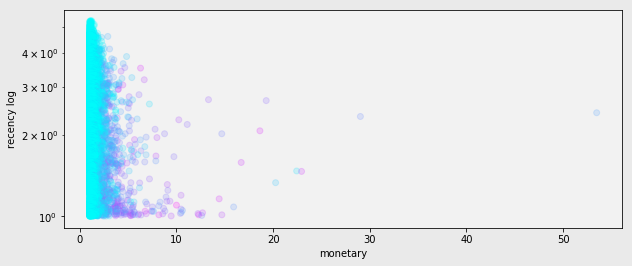

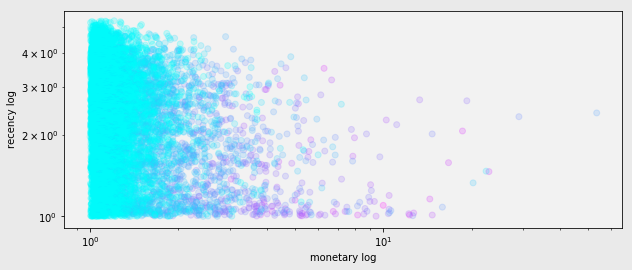

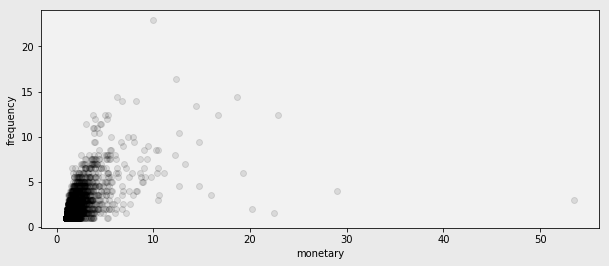

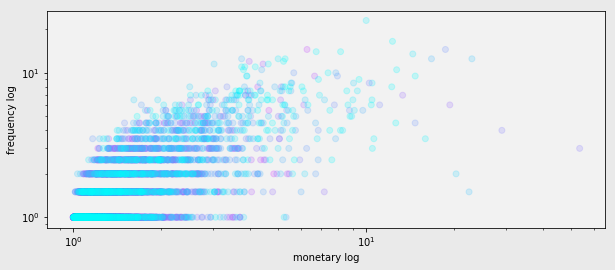

In [14]:
# Processed data are now in rmf
rmf_tmp = rmf.copy()
display(rmf.head())
#plot_scatter(rmf,'monetary', 'recency', with_hue = 0,  log_x=0, log_y=0)
# log() + 1
# Getting data to interval 1-inf so it can be log-plotted
rmf_tmp['monetary'] += abs(rmf_tmp['monetary'].min()) +1
rmf_tmp['recency'] += abs(rmf_tmp['recency'].min()) +1
rmf_tmp['frequency'] += abs(rmf_tmp['frequency'].min()) +1
plot_scatter(rmf_tmp,'monetary',  'recency', 'frequency', with_hue = 1,  log_x=0, log_y=1)
plot_scatter(rmf_tmp,'monetary',  'recency', 'frequency', with_hue = 1,  log_x=1, log_y=1)

plot_scatter(rmf_tmp,'monetary','frequency', 'recency', with_hue = 0,  log_x=0, log_y=0)
plot_scatter(rmf_tmp,'monetary','frequency', 'recency', with_hue = 1,  log_x=1, log_y=1)


## Hledání vhodného počtu shluků
Pro KMeans používám metodu lokte. Pro hiearchické shlukování dendrogramy.

In [15]:
from scipy.cluster.hierarchy import fcluster

# funkce na vykreslení grafu na vzniklé shluky ze 3 pohledů 
def plot_clusters(data, x, y, z, clusters, title):
    fig = plt.figure(figsize=(17,4))
    fig.patch.set_facecolor('#EAEAEA')
    pairs = [[x,y],[x,z],[z,y]]
    ax1 = fig.add_subplot(131)
    ax1.set_title('Front side')
    ax1.set_facecolor('#F2F2F2')
    ax2 = fig.add_subplot(132)
    ax2.set_title('From above')
    ax2.set_facecolor('#F2F2F2')
    ax3 = fig.add_subplot(133)
    ax3.set_title('Opposite side')
    ax3.set_facecolor('#F2F2F2')
    colors = list(range(0, np.amax(clusters)))
    
    ax1.scatter(data[pairs[0][0]],data[pairs[0][1]], c=clusters, cmap='Set1', alpha=0.3)
    ax1.set(xlabel=pairs[0][0], ylabel=pairs[0][1])
    ax2.scatter(data[pairs[1][0]],data[pairs[1][1]], c=clusters, cmap='Set1', alpha=0.3)
    ax2.set(xlabel=pairs[1][0], ylabel=pairs[1][1])
    ax3.scatter(data[pairs[2][0]],data[pairs[2][1]], c=clusters, cmap='Set1', alpha=0.3)
    ax3.set(xlabel=pairs[2][0], ylabel=pairs[2][1])
    
    fig.suptitle(title, fontsize=14)
    
    plt.show()

,frequency,recency,monetary
Customer ID,,,
7,0.623559,-1.089608,-0.344020
9,-0.371483,2.680430,-0.349759
30,-0.371483,2.646019,-0.293349
34,-0.371483,2.753381,-0.171209
38,-0.371483,2.745122,-0.287953


,frequency,recency,monetary
Customer ID,,,
7,3,1433,15.54
9,1,4172,13.20
30,1,4147,36.20
34,1,4225,86.00
38,1,4219,38.40


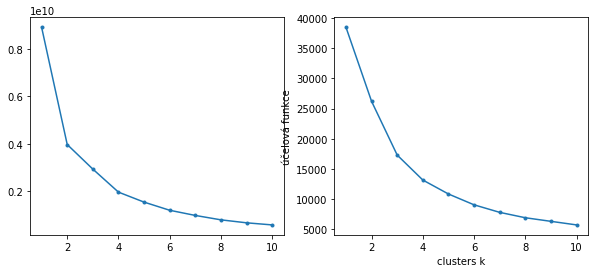

In [16]:
#metoda loktu aplikovaná na původní rmf data a na přeškálovaá data
import math

ix = np.zeros(10)
iy_rmf = np.zeros(10)
iy_norm = np.zeros(10)

# save normalized and standardized data in norm dataframe
norm = rmf.copy()
# get raw data
rmf = rmf_old.copy()

display(norm.head())
display(rmf.head())


for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans_norm = KMeans(n_clusters=k+1, random_state = 1)
    
    kmeans.fit(rmf)
    kmeans_norm.fit(norm)
    
    ix[k] = k+1
    
    iy_rmf[k] = kmeans.inertia_
    iy_norm[k] = kmeans_norm.inertia_


fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(ix, iy_rmf, '.-')
plt.xlabel('clusters k')
plt.ylabel('účelová funkce')
ax2.plot(ix, iy_norm, '.-')
plt.show()

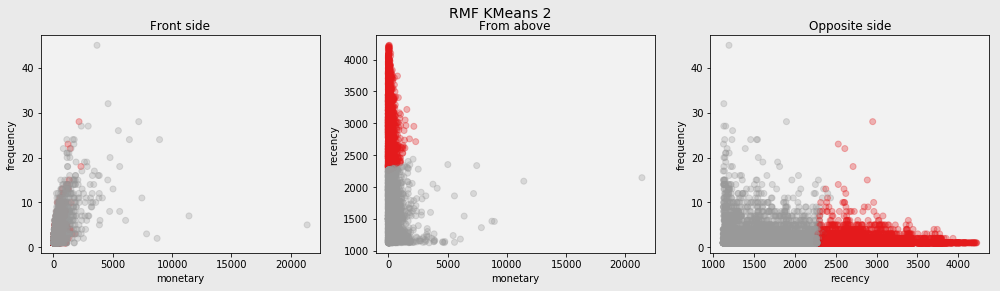

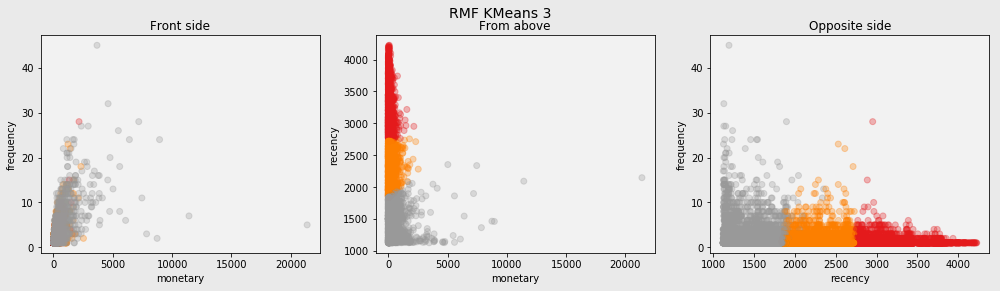

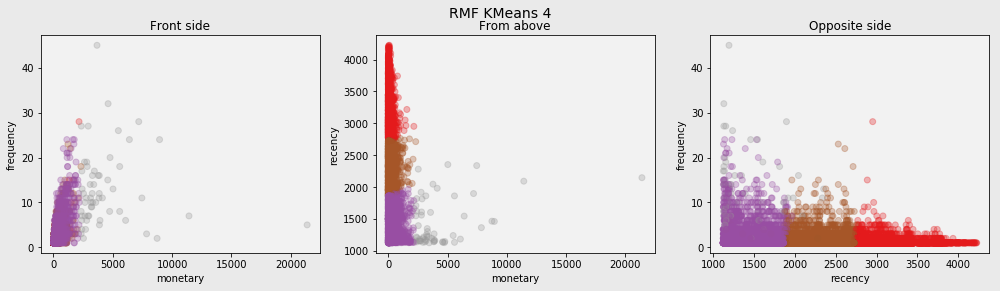

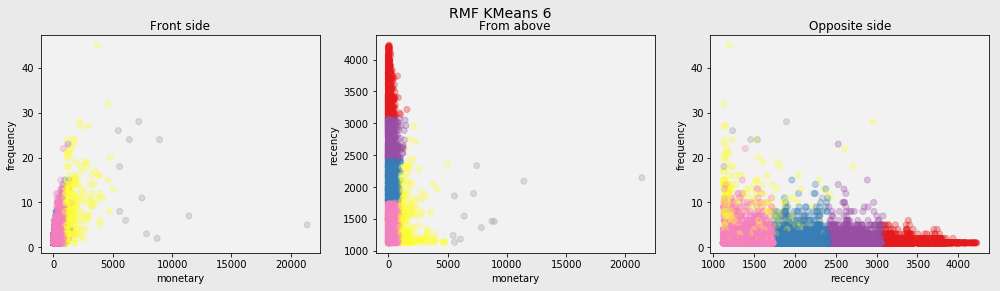

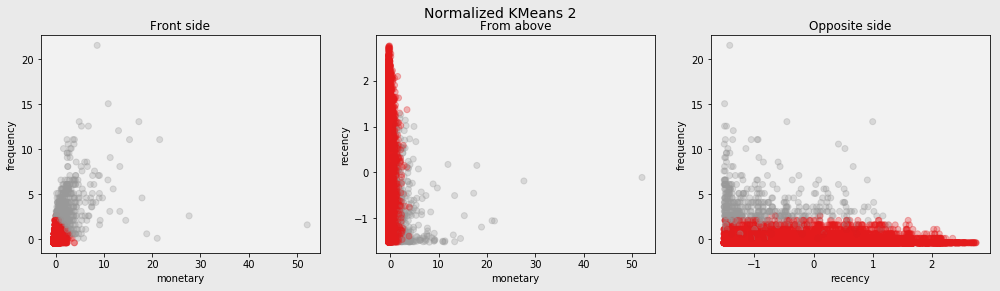

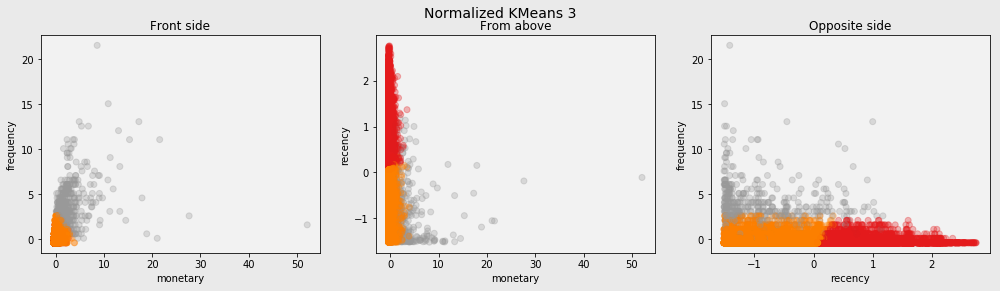

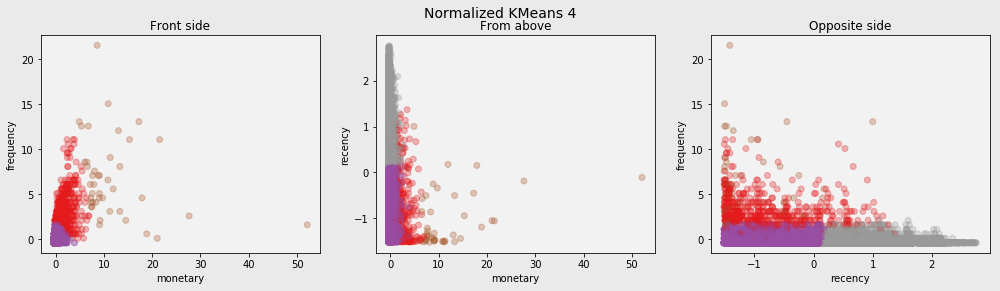

In [17]:
#Lets see results for raw RMF data for 2, 3, 4 and 6 clusters:
kmeans = KMeans(n_clusters = 2, random_state = 1).fit(rmf)
plot_clusters(rmf,  "monetary", "frequency", "recency", kmeans.labels_, "RMF KMeans 2")

kmeans = KMeans(n_clusters = 3, random_state = 1).fit(rmf)
plot_clusters(rmf,  "monetary", "frequency", "recency", kmeans.labels_, "RMF KMeans 3")

kmeans = KMeans(n_clusters = 4, random_state = 1).fit(rmf)
plot_clusters(rmf,  "monetary", "frequency", "recency", kmeans.labels_, "RMF KMeans 4")
kmeans_RMF_4 = kmeans.labels_

kmeans = KMeans(n_clusters = 6, random_state = 1).fit(rmf)
plot_clusters(rmf,  "monetary", "frequency", "recency", kmeans.labels_, "RMF KMeans 6")


#For normalized RFM data the elbow method looks best for 2 and 4 clusters:
kmeans = KMeans(n_clusters = 2, random_state = 1).fit(norm)
plot_clusters(norm,  "monetary", "frequency", "recency", kmeans.labels_, "Normalized KMeans 2")
kmeans_NORM_2 = kmeans.labels_

kmeans = KMeans(n_clusters = 3, random_state = 1).fit(norm)
plot_clusters(norm,  "monetary", "frequency", "recency", kmeans.labels_, "Normalized KMeans 3")

kmeans = KMeans(n_clusters = 4, random_state = 1).fit(norm)
plot_clusters(norm,  "monetary", "frequency", "recency", kmeans.labels_, "Normalized KMeans 4")



## Výsledky KMeans a metody lokte

Dle grafu ze zdá, že poměrně uspokojivé rozdělení pomocí alg. KMeans pro raw RFM data dostaneme pro 4 clustery, přičemž pro data normalizovaná data je toto číslo menší, což je logické vzhledem k tomu, že jsme data "zahustili" na menší interval.

Co se týče rozdělení dat na shluky, které jasně sdílí nějakou vlastnost, je velmi dobře vidět rozdělení zákazníků podle Recency. Bohužel u nepravených dat  je to málem jediný příznak podle kterého KMeans provedl shlukování, což je samozřejmě tím, že data jsou nejvíce rovnoměrně rozprostřena právě v této dimenzi. Proto až teprve pro 4 shluky je oddělen i shluk na jiné ose. 
Naopak u upravených dat je vidět, že algoritmus "správně" oddělil už první 2 shluky na shluk zákazníků s vysokou Monetary a Frequency, kteří ale nesdílí podobnou hodnotu Recency a ostatní.

Pro 4 shluky to vypadá, že se toto oddělení superstar zakazníků ještě o něco vylepšilo.

Z předešlých i z nových pohledů na data, se mi zdá, že bude potřeba i jiný pohled na data k rozdělení zákazníků do skupin, které už mohu trochu lépe označit, případně bude třeba data dále upravovat.

Dalším postupem proto bude sledování hiearchického rozdělení dat do shluků na dendrogramu podle jedotlivých metod měření vzdáleností shluků.

Pro každou metodu se podívám na rozdělení pro 3 shluky  - což vypadá jako vhodná hodnota podle metody lokte.
Dále i na rozdělení pro více shluků, přičemž počítám s tím, že pro každou metodu bude toto číslo jiné v závislosti na tom, jak účinně je shopna shlukovat outliery.

In [18]:
# matrix  - matice propojení
# max_d - maximální vzdálenost - proložení dendrogramu
def draw_dendrogram(matrix, max_d):
    # funkce na vykreslení dendrogramu převzata ze 4. cvičení
    fancy_dendrogram(
    matrix,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1.9,
    max_d = max_d,
    )
    plt.show()

## Wardova vzdálenost

6 clusters:


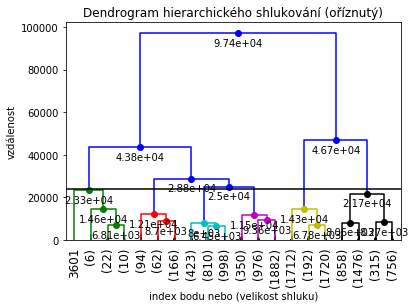

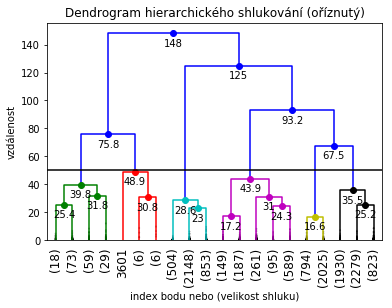

3 clusters:


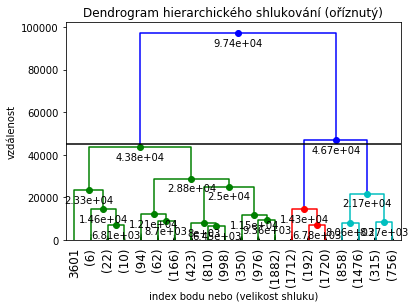

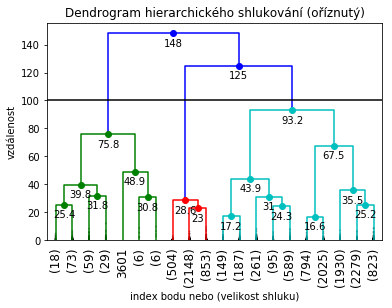

In [19]:
Z = linkage(rmf, 'ward')
Z_norm_mm = linkage(norm, 'ward')

# rozdeleni na 6 clusteru
print("6 clusters:")
draw_dendrogram(Z, 24e+03)
draw_dendrogram(Z_norm_mm, 50)

# rozdeleni na 3 clustery - podle metody lokte
print("3 clusters:")

draw_dendrogram(Z, 45e+03)
draw_dendrogram(Z_norm_mm, 100)

RMF data, Ward, 3 clusters:


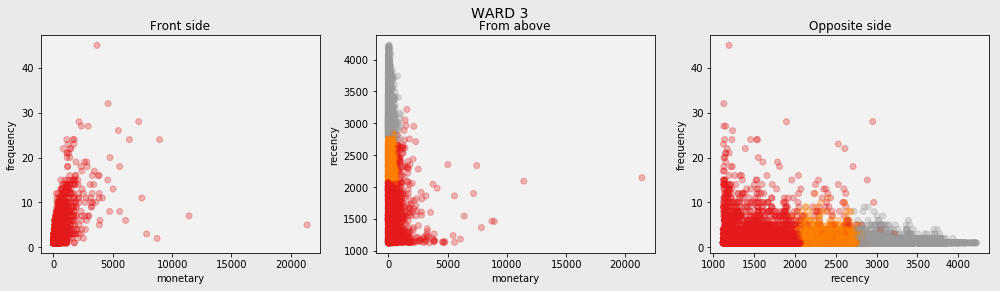

RMF data, Ward, 4 clusters:


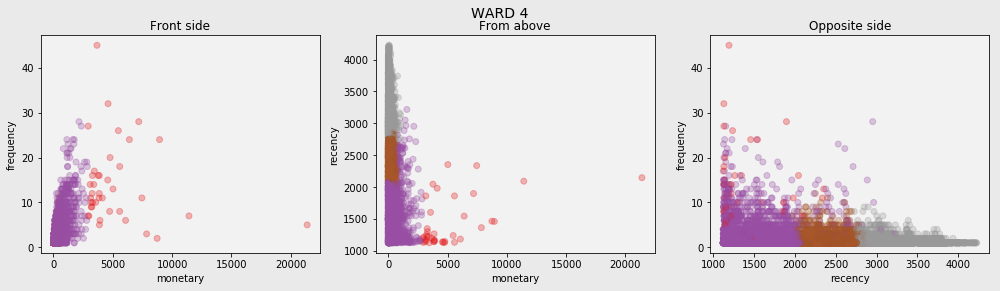

Normalized min-max, Ward, 3 clusters


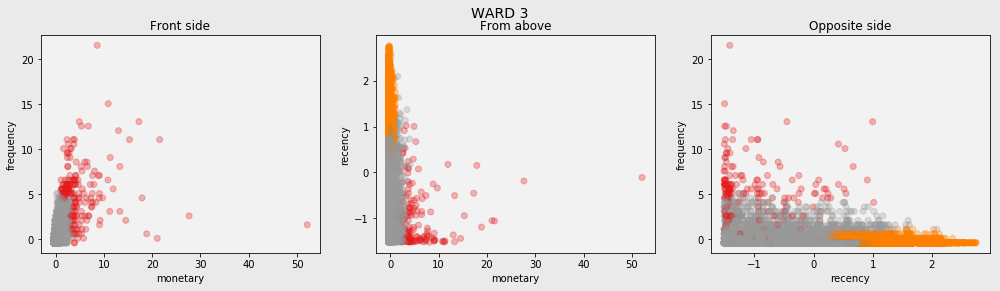

Normalized min-max, Ward, 4 clusters


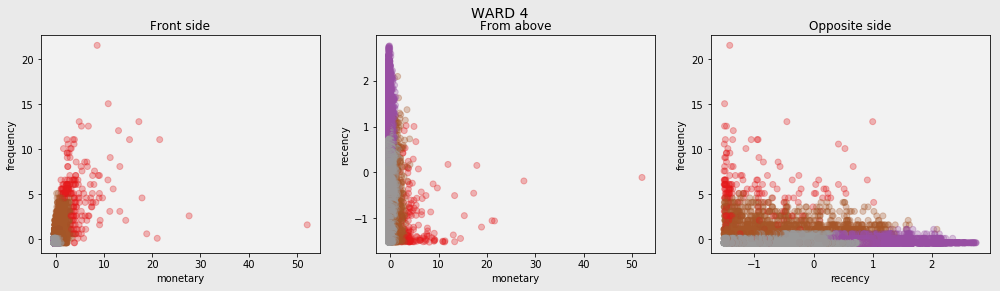

In [20]:
Z = linkage(rmf, 'ward')
Z_norm_mm = linkage(norm, 'ward')

clusters_rmf_4 = fcluster(Z, 30e+03, criterion='distance')
clusters_rmf_3 = fcluster(Z, 45e+03, criterion='distance')
clusters_mm_4 = fcluster(Z_norm_mm, 80, criterion='distance')
clusters_mm_3 = fcluster(Z_norm_mm, 100, criterion='distance')

print("RMF data, Ward, 3 clusters:")
plot_clusters(rmf,  "monetary", "frequency", "recency", clusters_rmf_3, "WARD 3") #one side

print("RMF data, Ward, 4 clusters:")
plot_clusters(rmf,  "monetary", "frequency", "recency", clusters_rmf_4, "WARD 4") #one side


print("Normalized min-max, Ward, 3 clusters")
plot_clusters(norm,  "monetary", "frequency", "recency", clusters_mm_3, "WARD 3") #one side

print("Normalized min-max, Ward, 4 clusters")
plot_clusters(norm,  "monetary", "frequency", "recency", clusters_mm_4, "WARD 4") #one side

ward_3_reds = clusters_mm_3


### Wardova metoda - závěr

Už na listech dendrogramu je vidět, že tato metoda funguje nejlépe na shlukování outlierů, jelikož v prvních 20ti shlucích se vyskytuje na nenormalizovaných datech pouze jeden nejvýraznější outlier jako samostatný shluk.

Na 6ti shlucích ve zpracovaných RMF datech lze pozorovat velmi malý světle modrý cluster, který představuje pár superstar zákazníků. Wardovo rozdělení na raw datech pro 6 shluků také poměrně dobře oddělilo zajímavé zákazníky a vycnechalo dle mého názoru příliš mnoho zákazníků s nižší monetary ale vysokou frequency.

## Average, Single a Complete

Tyto metody nepřinesly dobré výsledky - přespříliš oddělují outliery do samostatných shluků.

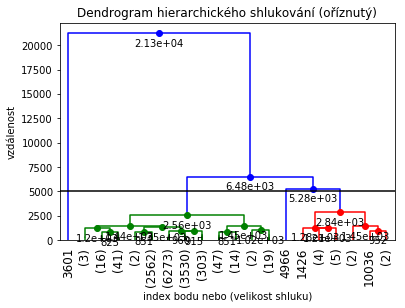

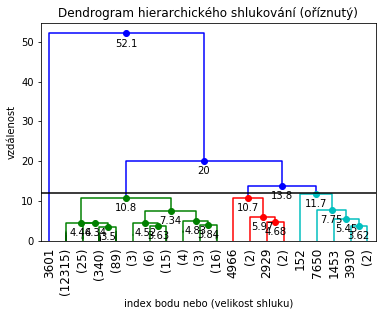

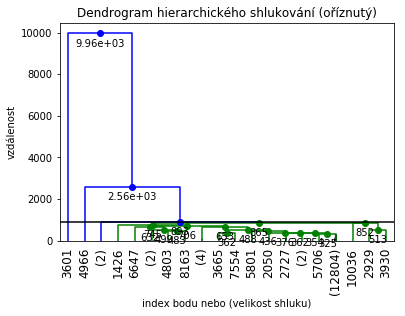

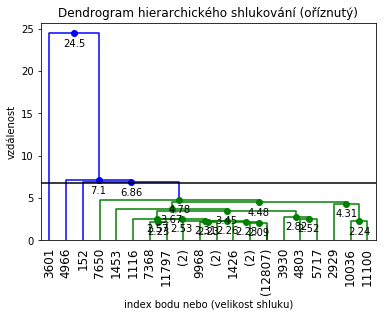

In [21]:
Z = linkage(rmf, 'average')
Z_norm_mm = linkage(norm, 'average')

# 4 clusters
draw_dendrogram(Z, 5e+03)
draw_dendrogram(Z_norm_mm, 12)

Z = linkage(rmf, 'single')
Z_norm_mm = linkage(norm, 'single')

# 4 clusters
draw_dendrogram(Z, 880)
draw_dendrogram(Z_norm_mm, 6.8)

In [22]:
"""# Vizualizace řezu v dendrogram
Z = linkage(rmf, 'average')
Z_norm_mm = linkage(norm_mm, 'average')

clusters_rmf_3 = fcluster(Z, 14, criterion='distance')
clusters_rmf_6 = fcluster(Z, 10.75, criterion='distance')
clusters_mm_3 = fcluster(Z_norm_mm, 0.7, criterion='distance')
clusters_mm_6 = fcluster(Z_norm_mm, 0.45, criterion='distance')

# Vizualizace
print("RMF data, Averge, 6 clusters:")
plot_clusters(rmf,  "monetary", "frequency", "recency", clusters_rmf_6, "Average") #one side
print("RMF data, Averge, 3 clusters:")
plot_clusters(rmf,  "monetary", "frequency", "recency", clusters_rmf_3, "Average")
# Vizualizace
print("Normalized min-max, Average, 6 clusters:")
plot_clusters(norm_mm,  "monetary", "frequency", "recency", clusters_mm_6, "Average") #one side
print("Normalized min-max, Average, 3 clusters:")
plot_clusters(norm_mm,  "monetary", "frequency", "recency", clusters_mm_3, "Average") #one side"""


'# Vizualizace řezu v dendrogram\nZ = linkage(rmf, \'average\')\nZ_norm_mm = linkage(norm_mm, \'average\')\n\nclusters_rmf_3 = fcluster(Z, 14, criterion=\'distance\')\nclusters_rmf_6 = fcluster(Z, 10.75, criterion=\'distance\')\nclusters_mm_3 = fcluster(Z_norm_mm, 0.7, criterion=\'distance\')\nclusters_mm_6 = fcluster(Z_norm_mm, 0.45, criterion=\'distance\')\n\n# Vizualizace\nprint("RMF data, Averge, 6 clusters:")\nplot_clusters(rmf,  "monetary", "frequency", "recency", clusters_rmf_6, "Average") #one side\nprint("RMF data, Averge, 3 clusters:")\nplot_clusters(rmf,  "monetary", "frequency", "recency", clusters_rmf_3, "Average")\n# Vizualizace\nprint("Normalized min-max, Average, 6 clusters:")\nplot_clusters(norm_mm,  "monetary", "frequency", "recency", clusters_mm_6, "Average") #one side\nprint("Normalized min-max, Average, 3 clusters:")\nplot_clusters(norm_mm,  "monetary", "frequency", "recency", clusters_mm_3, "Average") #one side'

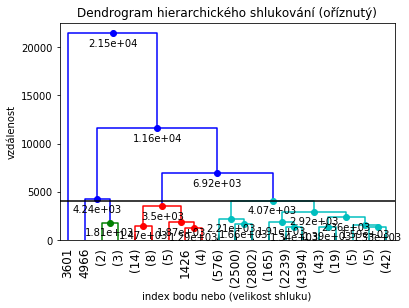

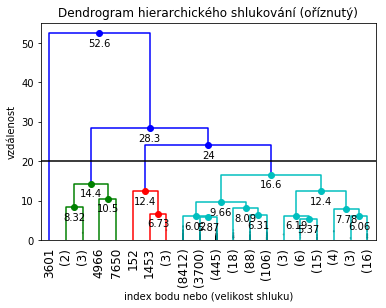

In [23]:
Z = linkage(rmf, 'complete')
Z_norm_mm = linkage(norm, 'complete')

# 4 clusters
draw_dendrogram(Z, 41e+02)
draw_dendrogram(Z_norm_mm, 20)

## Alternativní úprava dat
Jelikož největším problémem v normalizaci dat bylo nedostatečné rozprostření dat ve všech dimenzích, zkusím nejprve hodnoty zlogaritmovat a až poté je znormalizovat.



Input data: 


,frequency,recency,monetary
Customer ID,,,
7,1.386294,7.268223,2.805782
9,0.693147,8.336390,2.653242
30,0.693147,8.330382,3.616309
34,0.693147,8.349011,4.465908
38,0.693147,8.347590,3.673766


Min - Max Normalizing column:  frequency
Min - Max Normalizing column:  recency
Min - Max Normalizing column:  monetary


,frequency,recency,monetary
Customer ID,,,
7,3,1433,15.54
9,1,4172,13.20
30,1,4147,36.20
34,1,4225,86.00
38,1,4219,38.40


,frequency,recency,monetary
Customer ID,,,
7,0.221065,0.184466,0.220470
9,0.000000,0.990477,0.203875
30,0.000000,0.985943,0.308653
34,0.000000,1.000000,0.401086
38,0.000000,0.998928,0.314904


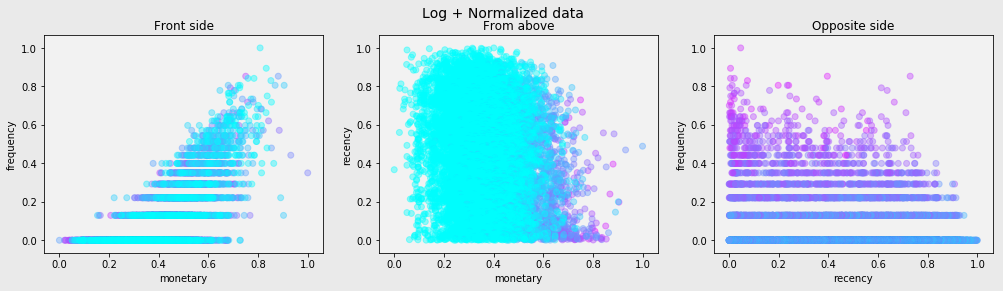

In [24]:
rmf_log = rmf_old.copy()
rmf_log += 1
rmf_log = np.log(rmf_log)
rmf_log = normalizeMinMax(rmf_log)

display(rmf_old.head())
display(rmf_log.head())

plot_norm(rmf_log,'monetary',  'frequency', 'recency', "Log + Normalized data")

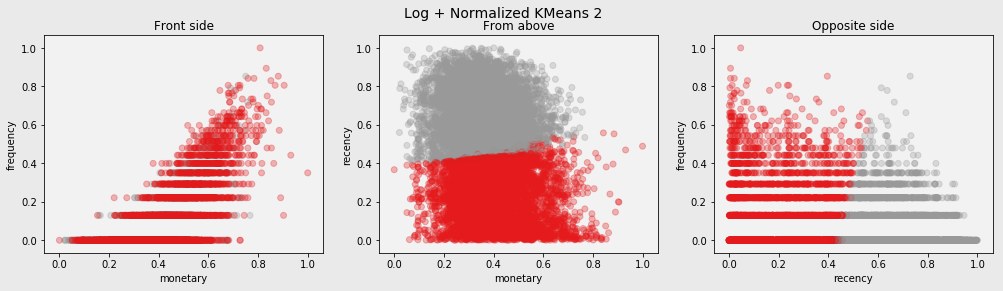

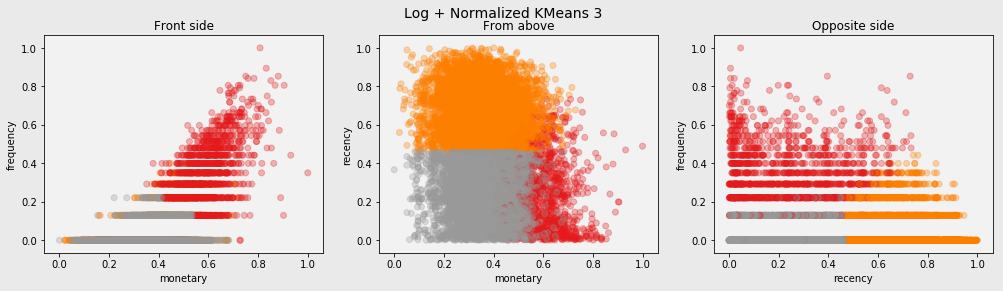

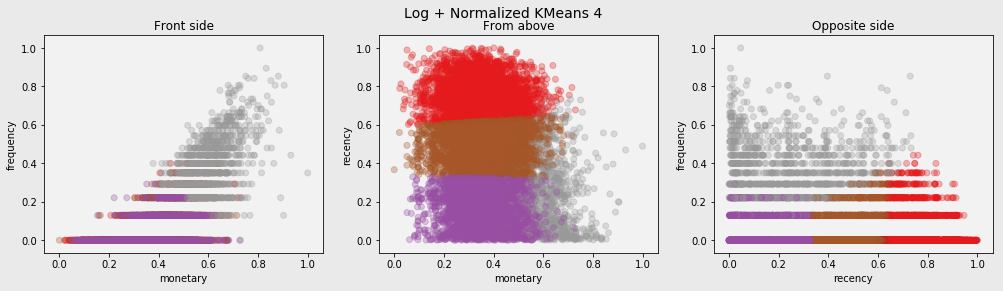

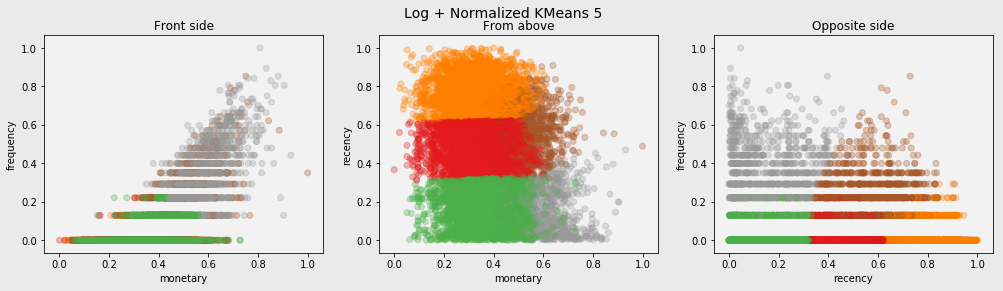

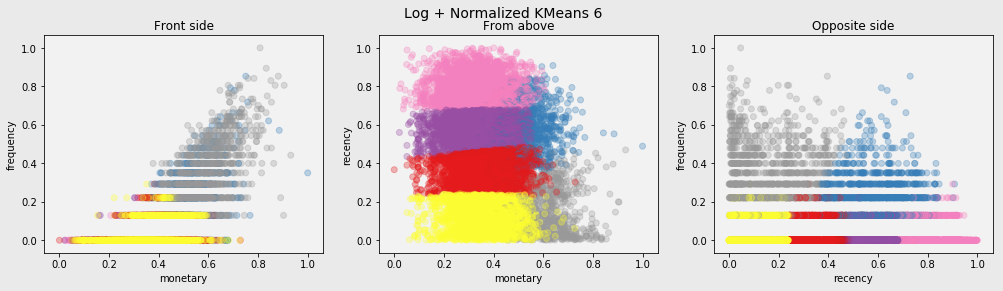

In [25]:
for k in range(2, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(rmf_log)
    title = "Log + Normalized KMeans " + str(k)
    plot_clusters(rmf_log,  "monetary", "frequency", "recency", kmeans.labels_, title)
    # ukládání shluků s ***
    if(k == 3):
        kmeans_3_labs = kmeans.labels_
    elif(k == 5):
        kmeans_5_labs = kmeans.labels_


Z grafů to vypadá, že KMeans na nových datech pro 5 (a i pro 3) shluků téměř ideálně oddělil tzv. superstar zákazníky - tedy ty co mají nízkou Recency, vysokou Frequency a vysokou Monetary. Jelikož ale takto upravená data mohou být klamavá podíváme se na vybrané zákazníky z těchto shluků do původních dat.

Pro větší počet shluků se opět rozdělují zákazníci podle Recency.

In [26]:
# Superstar customers from Log+Norm

original = rmf_old.copy()
old = rmf_old.copy()
old['superstar'] = kmeans_3_labs
b_idx = old.index[old['superstar'] == 0].tolist()

superstars_3 = rmf_old.copy()
superstars_3['superstar'] = original.index.isin(b_idx)*1


old = rmf_old.copy()
old['superstar'] = kmeans_5_labs
h_idx = old.index[old['superstar'] == 4].tolist()

superstars_5 = rmf_old.copy()
superstars_5['superstar'] = original.index.isin(h_idx)*1


Pro 3 shluky celkem vybrano superstar zakazniku: 1450


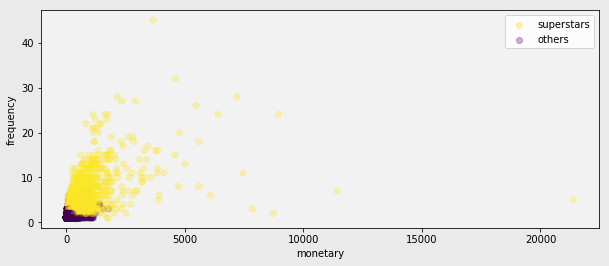

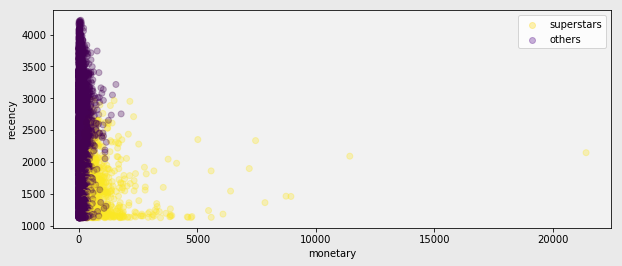

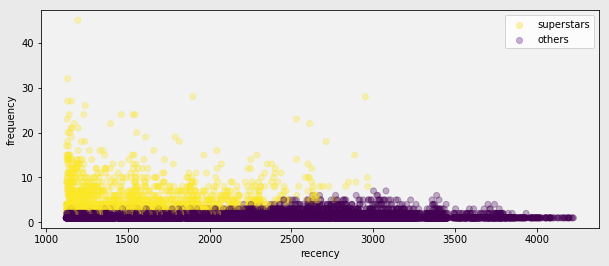

In [27]:
def plot_superstar(data, x, y):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('#EAEAEA')
    ax = fig.add_subplot(111)
    ax.set_facecolor('#F2F2F2')
    vysl = plt.scatter(x=data[x], y=data[y], c=data['superstar'], cmap='viridis', alpha=0.3)
    leg = ax.legend((vysl, vysl), ("superstars", "others"))
    leg.legendHandles[0].set_color('gold')
    leg.legendHandles[1].set_color('indigo')
    x_lab = x
    y_lab = y
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    plt.show()

print("Pro 3 shluky celkem vybrano superstar zakazniku:", len(b_idx))
plot_superstar(superstars_3, "monetary", "frequency")
plot_superstar(superstars_3, "monetary", "recency")
plot_superstar(superstars_3, "recency", "frequency")

Pro 5 shluku bylo celkem vybrano superstar zakazniku: 1023


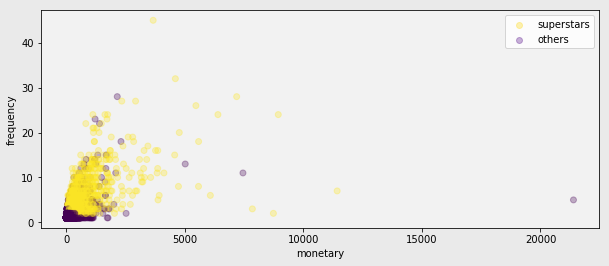

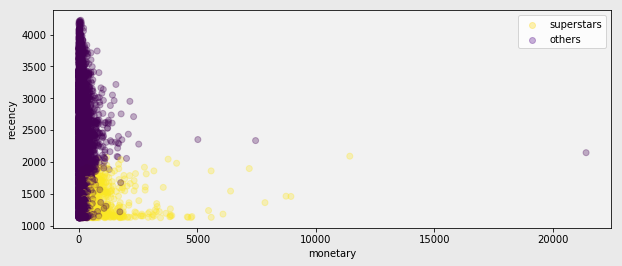

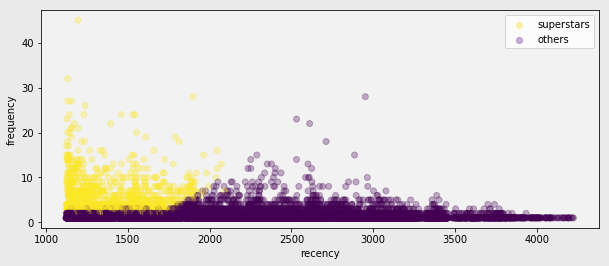

In [28]:
print("Pro 5 shluku bylo celkem vybrano superstar zakazniku:", len(h_idx))
plot_superstar(superstars_5, "monetary", "frequency")
plot_superstar(superstars_5, "monetary", "recency")
plot_superstar(superstars_5, "recency", "frequency")

### Srovnání se shluky získanými v předešlé sekci
Z grafu je videt, ze množina superstar zakazniku z 5 shluku je omezená na aktuálnější zákazníky. Bylo by proto třeba vědět co přesně je cílem analýzy, aby bylo možné dále vybírat (ne)vhodné clustery.



Pro 3 shluky vybrané hiearchickým shlukováním (Ward) bylo celkem vybrano superstar zakazniku: 192


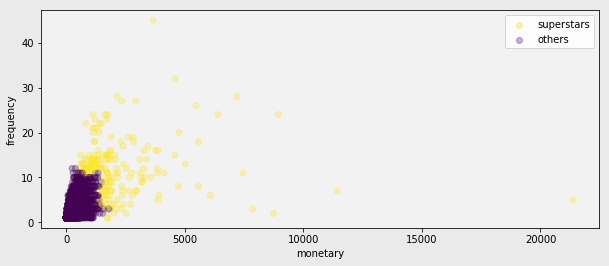

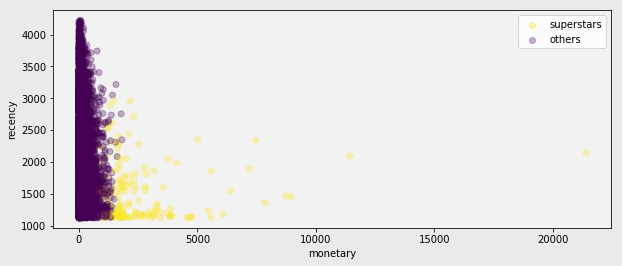

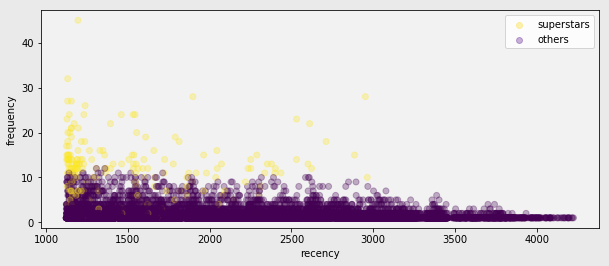

In [29]:
# Superstar customers from Ward
#display(ward_3_reds)
old = rmf_old.copy()
old['superstar'] = ward_3_reds
h_idx = old.index[old['superstar'] == 1].tolist()

ward_reds = rmf_old.copy()
ward_reds['superstar'] = original.index.isin(h_idx)*1

print("Pro 3 shluky vybrané hiearchickým shlukováním (Ward) bylo celkem vybrano superstar zakazniku:", len(h_idx))
plot_superstar(ward_reds, "monetary", "frequency")
plot_superstar(ward_reds, "monetary", "recency")
plot_superstar(ward_reds, "recency", "frequency")

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

Pro raw RFM 4 shluky vybrané KMeans bylo celkem vybrano superstar zakazniku: 57


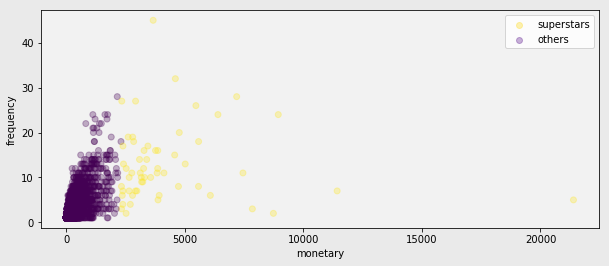

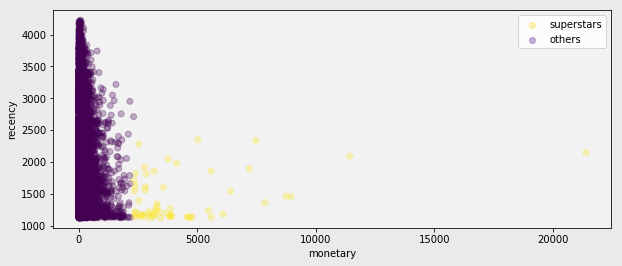

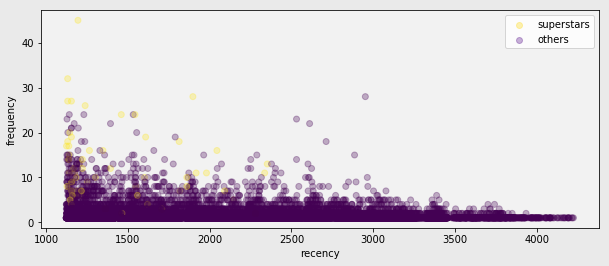

In [30]:
# Superstar customers from KMeans elbow

#raw RFM by KMeans for 4 clusters
#kmeans_RMF_4
display(kmeans_RMF_4)
old = rmf_old.copy()
old['superstar'] = kmeans_RMF_4
h_idx = old.index[old['superstar'] == 3].tolist()

kmeans_rmf = rmf_old.copy()
kmeans_rmf['superstar'] = original.index.isin(h_idx)*1

print("Pro raw RFM 4 shluky vybrané KMeans bylo celkem vybrano superstar zakazniku:", len(h_idx))
plot_superstar(kmeans_rmf, "monetary", "frequency")
plot_superstar(kmeans_rmf, "monetary", "recency")
plot_superstar(kmeans_rmf, "recency", "frequency")

Pro normalized and standardized data  a 2 shluky vybrané KMeans bylo celkem vybrano superstar zakazniku: 516


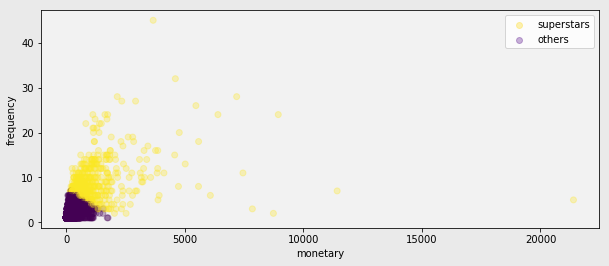

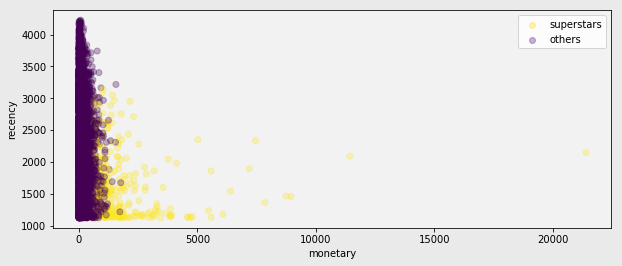

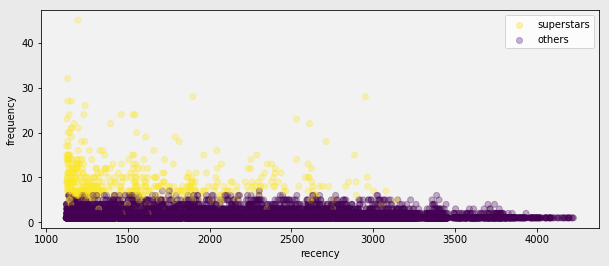

In [32]:
#Normalized RMF by KMeans for 2 clusters
old = rmf_old.copy()
old['superstar'] = kmeans_NORM_2
h_idx = old.index[old['superstar'] == 1].tolist()

kmeans_norm = rmf_old.copy()
kmeans_norm['superstar'] = original.index.isin(h_idx)*1

print("Pro normalized and standardized data  a 2 shluky vybrane KMeans bylo celkem vybrano superstar zakazniku:", len(h_idx))
plot_superstar(kmeans_norm, "monetary", "frequency")
plot_superstar(kmeans_norm, "monetary", "recency")
plot_superstar(kmeans_norm, "recency", "frequency")

Z výsledků se mi osobně nejvíce zamlouvá KMeans nad normalizovanými a standardizovanými daty pro 2 shluky, jelikož správně odděluje zákazníky s velmi nízkou monetary a frequency ale oproti jiným metodám nezahazuje zákazníky s vysokou frequency a poměrně nízkou monetary, což je myslím důležité máme-li posuzovat "věrnost" zákazníků.

Za druhý nejvyvedenější výsledek považuji hiearchické shlukování Wardovou metodou pro 3 shluky, taktéž nad upravenými daty.

Alternativní předzpracování dat pomocí logaritmování hodnot pomohlo lépe oddělit zákazníky s vysokou recency, nicméně záleží na konkrétním použití analýzy zákazníků, proto tento výsledek nemusí být žádoucí.